In [278]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [280]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from plot_functions import theta_pairs, mcmc_trace, param_stats

Consider a situation similar to the previous ball drop example; however, now consider different types of balls that have different densities. The four types of balls, baseball, basketball, bowling ball, and softball, are again dropped from a tower. Each type of ball has a unique radius $R$ and density $\rho$. Each ball is dropped from heights of 20, 40, and 60 meters.

We will generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{2}\frac{3\rho_{air}}{4R_{ball}\rho_{ball}}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $\rho_{air}=1.184 kg/m^3$ is the density of air, $R_{ball}$ is the radius of the ball, $\rho_{ball}$ is the density of the ball, and $g$ and $C$ are the coefficients of gravity and drag as defined in our previous example. The observation data model is given by equation (1) and $g$ and $C$ are both considered unknown. The goal is to jointly estimate these parameters.

There are three experiments for each type of ball corresponding to the heights of 20, 40, and 60 meters. The baseball, basketball, bowling ball, and softball have radii $0.0380, 0.12, 0.11, 0.0485$ meters and densities $626, 84, 1304, 380.9 \; kg/m^3$. A space filling Latin hypercube design selects the m=20 (C,g) design pairs for the simulator runs, shown in a scatter below. The simulator produces a curve of n=100 height-time pairs, where the simulation heights are evenly spaced in $[0,100]$ meters. Each of these 20 parameter settings are run for each of the four balls.

Read in data

x       : Radius and Density for Baseball, Basketball, Bowling Ball, Softball  
t_sim   : LH generated simulation design points  
h_field : oberservational heights for each experiment  
h_sim   : simulator heights  
y_field : time-height curve for experiment  
y_sim   : time-height curve for simulator

In [281]:
import os
datadir = os.getcwd()+"/data/ball_drop_2/"
# experimental data
with open(datadir+'fieldDat12x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
print('field_data',field_data.shape)

x_obs = x
y_obs = np.reshape(field_data[:,4],(4,3)) # observed times, experiments by row
h_obs = field_data[0:3,3]                 # observed heights

print('x_obs',x_obs.shape)
print('y_obs',y_obs.shape)
print('h_obs',h_obs.shape)

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

print('x_sim',x_sim.shape)
print('t_sim',t_sim.shape)
print('y_sim',y_sim.shape)
print('h_sim',h_sim.shape)

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)


field_data (12, 6)
x_obs (4, 2)
y_obs (4, 3)
h_obs (3,)
x_sim (80, 2)
t_sim (80, 2)
y_sim (80, 101)
h_sim (101,)


t (parameters): Latin Hyper cube design for $(C,g)$ pairs

(Text(0, 0.5, 'C'), Text(0.5, 1.0, 'Simulation Design'))

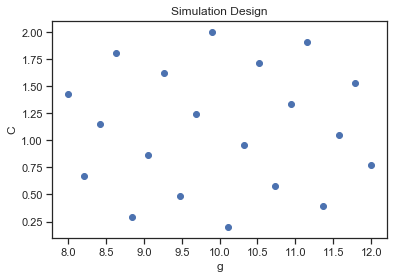

In [282]:
plt.scatter(t_sim[0:20,1],t_sim[0:20,0])
plt.xlabel("g");plt.ylabel("C"),plt.title("Simulation Design")

In [283]:
data.transform_xt()
data.standardize_y()

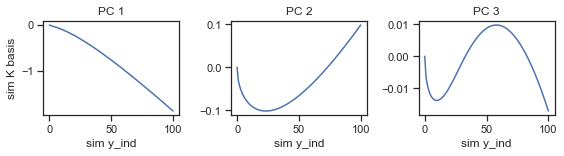

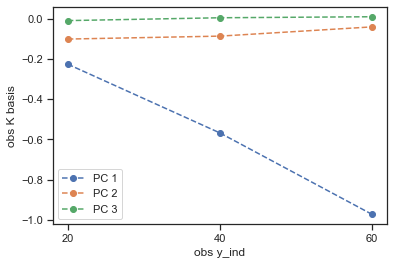

In [284]:
data.create_K_basis(3)
data.plot_K_basis()

In [285]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension 3
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



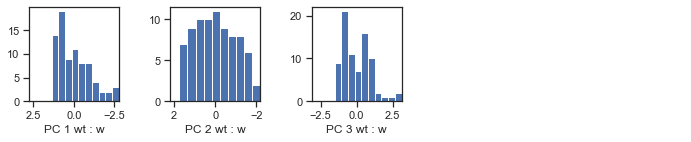

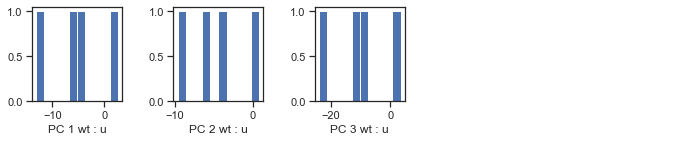

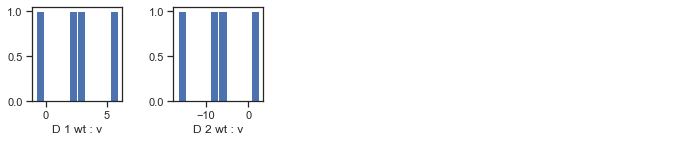

In [286]:
data.plot_K_weights()
#data.plot_K_residuals()

In [287]:
model = setup_model(data)
cachefile_name='ball_drop_2.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


In [288]:
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}

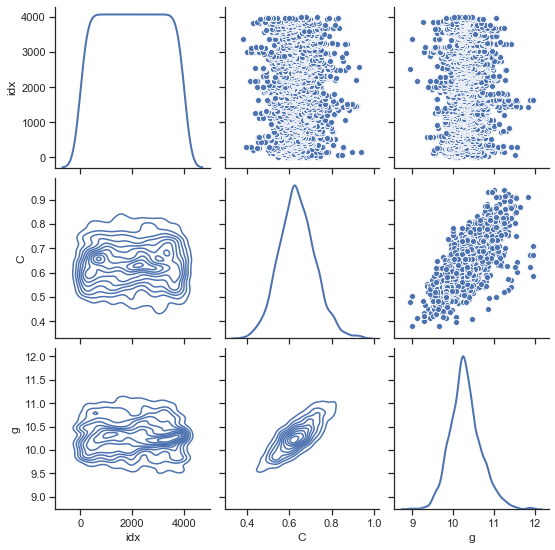

In [295]:
theta_names = ['C','g']
SepiaPlot.theta_pairs(samples_dict,theta_names)

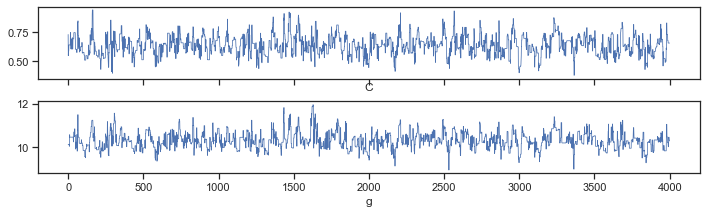

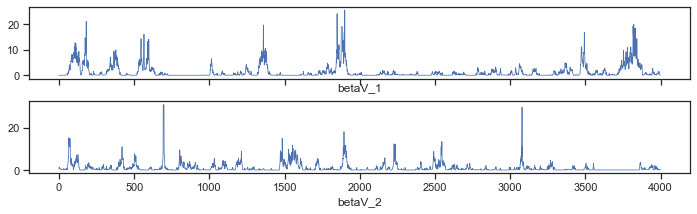

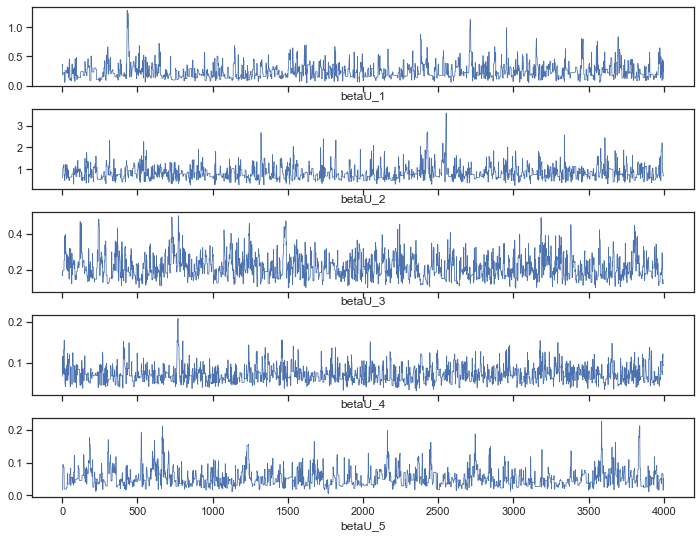

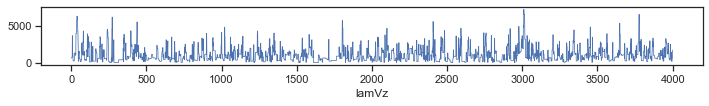

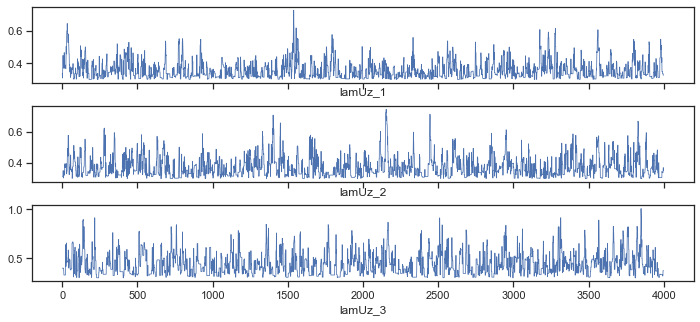

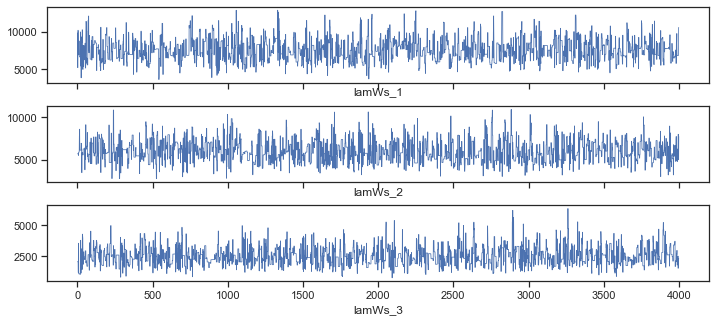

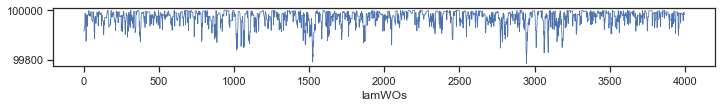

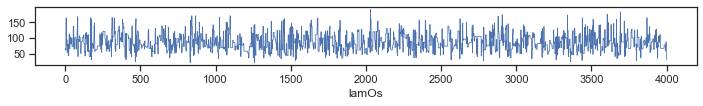

In [290]:
SepPlot.mcmc_trace(samples_dict,theta_names)

In [291]:
p_stats = SepiaPlot.param_stats(samples_dict,theta_names)
print(p_stats)

                  mean           sd
C             0.637576     0.085245
g            10.305926     0.381183
betaV_1       1.364537     2.693862
betaV_2       1.100111     2.306832
betaU_1       0.241249     0.134793
betaU_2       0.834178     0.321001
betaU_3       0.214159     0.065992
betaU_4       0.072366     0.020538
betaU_5       0.052340     0.027248
betaU_6       0.111291     0.057065
betaU_7       0.883911     0.164846
betaU_8       0.349920     0.081984
betaU_9       0.658642     0.482679
betaU_10      0.885712     0.495761
betaU_11      2.701141     0.484654
betaU_12      0.034596     0.015590
lamVz      1045.229705   989.744947
lamUz_1       0.355387     0.054749
lamUz_2       0.372385     0.066562
lamUz_3       0.441438     0.115133
lamWs_1    7586.177159  1439.607911
lamWs_2    5983.036657  1276.521966
lamWs_3    2555.726208   754.787557
lamWOs    99970.915106    29.955539
lamOs        86.137153    26.719068


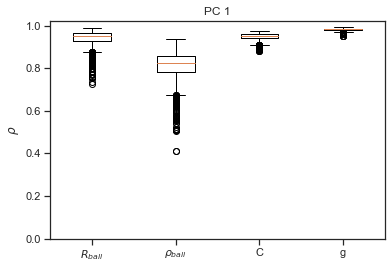

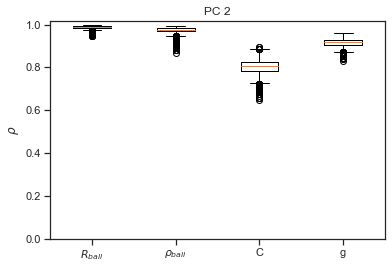

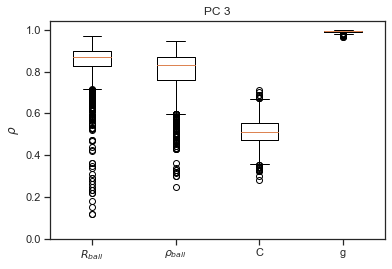

In [292]:
p = 2
q = 2
pu = 3
# rho box plots
bu = samples_dict['betaU']
ru = np.exp(-bu / 4)
for i in range(pu):
    r = ru[:, ((p+q)*i):((p+q)*i)+(p+q)]
    plt.boxplot(r)
    plt.xticks([1,2,3,4],[r'$R_{ball}$',r'$\rho_{ball}$','C','g'])
    plt.yticks(np.arange(0,1.2,.2))
    plt.ylabel(r'$\rho$')
    plt.title('PC {}'.format(i+1))
    plt.show()

----
## Predictions of model output from the full model

First, predictions showing just the emulator response, using
SepiaEmulatorPredict

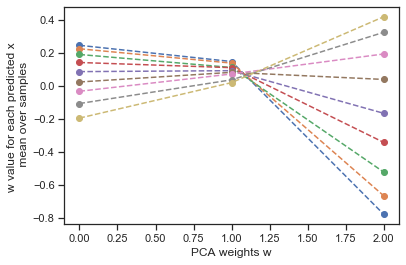

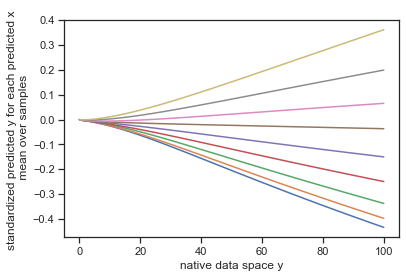

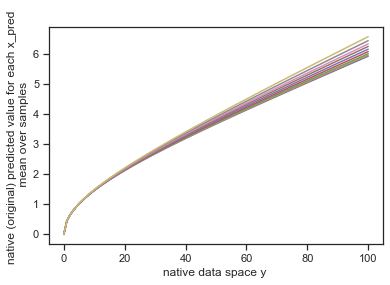

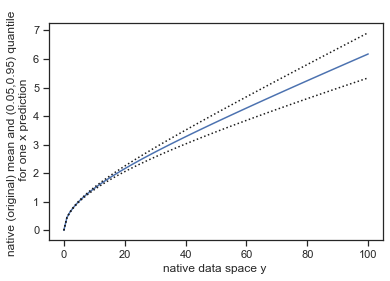

In [293]:
model.verbose=True

from sepia.SepiaPredict import SepiaEmulatorPrediction
x_pred=np.linspace(0,1,9)
# this number 3 is extremely important, but why? we have to play with it to make broadcasting work
# we have 2 thetas
t_pred=0.5*np.ones((9,3)) 
pred_samples=model.get_samples(numsamples=7)
pred=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model, theta_pred=t_pred)

predw=pred.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T,'--o')
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

predystd=pred.get_y_standardized()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

predy=pred.get_y_native()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

predy=pred.get_y_native()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,4,:],0).T)
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.show()

And below are similar predictions for the full models responses joint u and v

In [294]:
from sepia.SepiaPredict import SepiaFullPrediction
x_pred=np.linspace(0,1,9)
pred_samples=model.get_samples(numsamples=7)
pred=SepiaFullPrediction(x_pred, pred_samples, model)

plt.figure()
predu, predv = pred.get_u_v()
plt.subplot(2,1,1)
plt.plot(np.mean(predu,0).T)
plt.xlabel('PCA weights u')
plt.ylabel('u value for each predicted x \n mean over samples')
plt.subplot(2,1,2)
plt.plot(np.mean(predv,0).T,'*')
plt.xlabel('PCA weight v (scalar)')
plt.ylabel('v value for each predicted x \n mean over samples')
plt.show()

predysimstd=pred.get_ysim_standardized()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted ysim for each predicted x \n mean over samples')
plt.show()

preddstd=pred.get_discrepancy_standardized()
predd=pred.get_discrepancy_native()
plt.figure()
plt.subplot(2,1,1)
plt.plot(model.data.obs_data.y_ind,np.mean(preddstd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('standardized predicted discrepancy\n mean over samples')
plt.subplot(2,1,2)
plt.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('native predicted discrepancy \n mean over samples')
plt.show()

predyobs=pred.get_yobs_native()
plt.figure()
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs,0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs for each predicted x \n mean over samples')
plt.show()

ValueError: operands could not be broadcast together with shapes (36,4) (36,3) 

### Summary plot of predicted uncertainty for an observation.
The 5th prediction done corresponds to the observation in the model, with xpred=0.5.

In [ ]:
predyobs=pred.get_yobs_native()
predysim=pred.get_ysim_native()
plt.figure()
plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y.T,'r')
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs[:,4,:],0).T,'k--')
plt.plot(model.data.obs_data.y_ind,np.quantile(predyobs[:,4,:],[0.05, 0.95],axis=0).T,'k:')
plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,4,:],0).T,'g--')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
plt.legend(['obs','pred mean','pred 10/95', '_nolegend_', 'pred sim'])
plt.show()
